In [1]:
%matplotlib inline
from evaluator import evaluate, calc_impact, create_functions_in_db
from definitions import Repository
import db
import smells
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,3)

if not db.prepare("postgresql://"+(input("db username [postgres]") or "postgres")+":"+input("db password")+"@"+(input("db host [localhost]") or "localhost")+":"+(input("db port [5432]") or "5432")+"/"+input("db name")):
    print("Can't connect to db")
    exit()

# Ewaluacja

In [2]:
repo = input("repository")

## Udział smelly prs wśród badanych prs

In [3]:
smells_evaluations = [
    evaluate(repo, smells.lack_of_review),
    evaluate(repo, smells.missing_description),
    evaluate(repo, smells.large_changesets),
    evaluate(repo, smells.sleeping_reviews),
    evaluate(repo, smells.review_buddies),
    evaluate(repo, smells.ping_pong),
    evaluate(repo, smells.union,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong]),
    evaluate(repo, smells.intersection,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong])
]

In [4]:
# display results as text
for evaluation in smells_evaluations:
    print(evaluation)

Lack of code review           	93.71%
Missing PR description        	24.04%
Large changeset               	6.07%
Sleeping reviews              	50.79%
Review Buddies                	0.00%
Ping-pong reviews             	0.00%
At least one of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	98.65%
All of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	0.00%


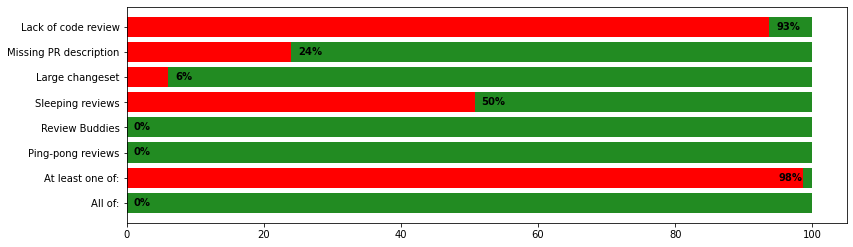

In [14]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e.evaluator_name.split("\n")[0], smells_evaluations))
ys = list(map(lambda e: e.percentage*100, smells_evaluations))
ax.barh(xs, 100, color="forestgreen")
ax.barh(xs, ys, color="red")
for i, v in enumerate(ys):
    ax.text(v + 1 if v<95 else 95, i + 0.1, f"{int(v)}%", color="black", fontweight="bold")
ax.invert_yaxis()
plt.show()

## Wpływ smelli na prawdopodobieństwo wprowadzenia błędu

In [6]:
dbsession = db.getSession()
repo_obj: Repository = dbsession.query(Repository).filter(Repository.full_name == repo).first()

if repo_obj is None:
    print("Repository not found")
    exit()

create_functions_in_db(dbsession)

impact_evaluations = list(map(lambda pair: (pair[0], calc_impact(dbsession, repo_obj, pair[1])), [
        ("Lack of code review", smells.lack_of_review),
        ("Missing PR description", smells.missing_description),
        ("Large changeset", smells.large_changesets),
        ("Sleeping reviews", smells.sleeping_reviews),
        ("Review Buddies", smells.review_buddies),
        ("Ping-pong reviews", smells.ping_pong)

    ]))

In [7]:
# display results as text
print(
    f"Prawdopodobieństwa, że dla przynajmniej jednego z plików zmodyfikowanych "
    f"przez dany PR następna edycja zostanie dokonana przez bug solving PR:")
print(f"{''.ljust(30)}OK    \t SMELLY\t IMPACT")

for (name, res) in impact_evaluations:
    print(f"{name.ljust(30)}{(res[0] * 100):.2f}%\t {(res[1] * 100):.2f}%\t {'+' if res[1]>res[0] else ''}{((res[1]-res[0]) * 100):.2f}%")

Prawdopodobieństwa, że dla przynajmniej jednego z plików zmodyfikowanych przez dany PR następna edycja zostanie dokonana przez bug solving PR:
                              OK    	 SMELLY	 IMPACT
Lack of code review           60.71%	 58.99%	 -1.72%
Missing PR description        60.36%	 55.14%	 -5.21%
Large changeset               57.66%	 81.48%	 +23.83%
Sleeping reviews              57.53%	 60.62%	 +3.09%
Review Buddies                59.10%	 nan%	 nan%
Ping-pong reviews             59.10%	 nan%	 nan%


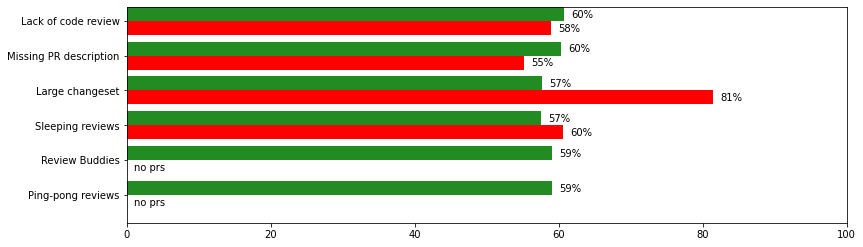

In [11]:
import numpy as np

# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e[0], impact_evaluations))
for_ok = list(map(lambda e: e[1][0]*100, impact_evaluations))
for_smelly = list(map(lambda e: e[1][1]*100, impact_evaluations))
ind = np.arange(len(xs))
width = 0.4

ax.barh(ind, for_ok, width, color="forestgreen")
for i, v in enumerate(for_ok):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + 0.1, f"{int(v)}%" if v==v else "no prs", color="black")
ax.barh(ind + width, for_smelly, width, color="red")
for i, v in enumerate(for_smelly):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + width + 0.1, f"{int(v)}%" if v==v else "no prs", color="black")
ax.set(yticks=ind + width/2, yticklabels=xs, ylim=[2*width-1, len(xs)], xlim=[0, 100])
ax.invert_yaxis()
plt.show()